In [56]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix

warnings.filterwarnings('ignore')

## Read Train data

In [35]:
train_home_team_statistics_df = pd.read_csv('../data/Train/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('../data/Train/train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('../data/Train/Y_train_1rknArQ.csv', index_col=0)


In [36]:
train_home = train_home_team_statistics_df
train_away = train_away_team_statistics_df

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)

# Restrict the model to Ligue 1
mask_ligue1 = train_data['HOME_LEAGUE'] == "Ligue 1"
train_data = train_data[mask_ligue1]

train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan}) 


In [37]:
# Restrict the columns to the ones containing '5_last_match' in their names, and the league and team names
mask = train_data.columns.str.contains('5_last_match') | train_data.columns.str.contains('LEAGUE') | train_data.columns.str.contains('TEAM_NAME')

# Keep the mask columns and the league and team names
train_data = train_data.loc[:,mask]

In [38]:
train_data.shape

(851, 144)

In [39]:
train_scores.shape

(851, 3)

## Benchmark

We try to model if HOME wins

In [40]:
train_new_y = train_scores['HOME_WINS']

# Set HOME_LEAGUE, HOME_TEAM_NAME, AWAY_LEAGUE, AWAY_TEAM_NAME to categorical
train_data['HOME_LEAGUE'] = train_data['HOME_LEAGUE'].astype('category')
train_data['HOME_TEAM_NAME'] = train_data['HOME_TEAM_NAME'].astype('category')
train_data['AWAY_LEAGUE'] = train_data['AWAY_LEAGUE'].astype('category')
train_data['AWAY_TEAM_NAME'] = train_data['AWAY_TEAM_NAME'].astype('category')

In [ ]:
train_new_y.value_counts() / train_new_y.shape[0]

HOME_WINS
0    0.580494
1    0.419506
Name: count, dtype: float64

In [67]:
y_test.value_counts() / y_test.shape[0]

HOME_WINS
0    0.614035
1    0.385965
Name: count, dtype: float64

In [68]:
y_train.value_counts() / y_train.shape[0]

HOME_WINS
0    0.572059
1    0.427941
Name: count, dtype: float64

### train, test split

In [41]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42)

### xgb model

Accuracy: 0.6491228070175439
F1: 0.5522388059701493


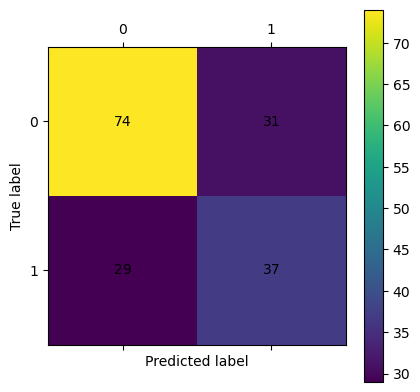

In [61]:
# Train XGBoost classifier to predict if home team wins
model = xgb.XGBClassifier(enable_categorical=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")

# Plot the confusion matrix
plt.matshow(matrix)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
# Add the numbers in the boxes
for (i, j), val in np.ndenumerate(matrix):
    plt.text(j, i, f'{val}', ha='center', va='center')
plt.show()

### Some analysis

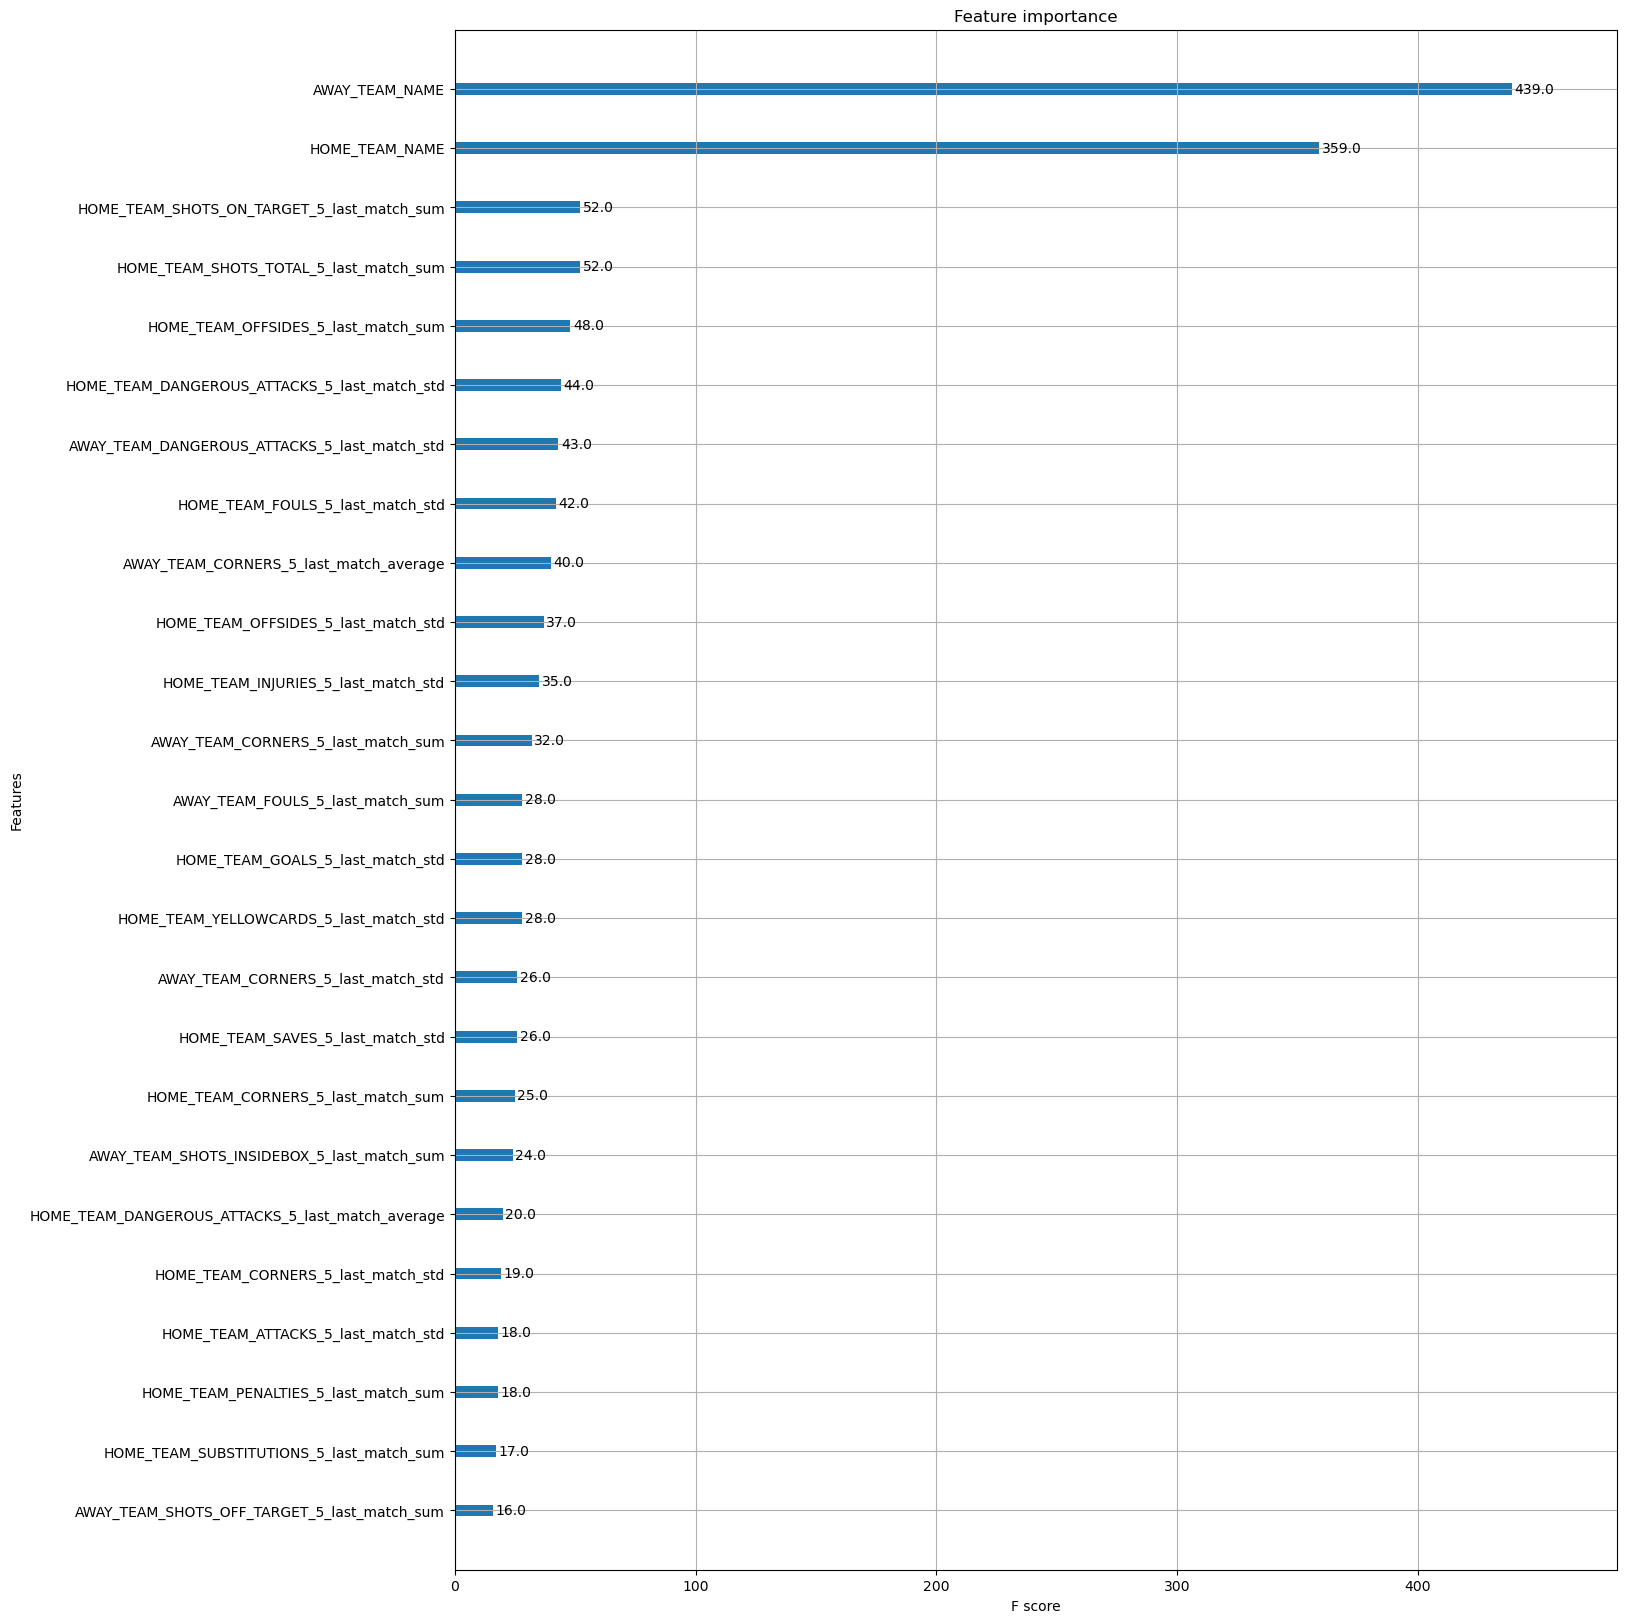

In [53]:
xgb.plot_importance(bst, max_num_features=25)
fig = plt.gcf()
fig.set_size_inches(15, 20)


### Accuracy on test set

A simple benchmark is always predicting home wins

In [54]:
target = train_scores.loc[X_test.index].copy()

home_wins = target
home_wins = 0 * home_wins
home_wins.iloc[:,0] = 1

np.round(accuracy_score(home_wins,target),4)


0.386

Using our model

In [55]:
X_test_xgb = xgb.DMatrix(X_test, enable_categorical=True)

predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values
np.round(accuracy_score(predictions,target),4)


0.2749